In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

inputImg=np.float32(cv2.imread("../data/inputs/p1.png",0))
#inputImg= cv2.cvtColor(inputImg, cv2.COLOR_BGR2RGB)
refImg=np.float32(cv2.imread("../data/inputs/style.png",0))
#refImg= cv2.cvtColor(refImg, cv2.COLOR_BGR2RGB)





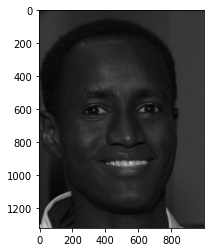

In [2]:
plt.imshow(inputImg,cmap="gray")

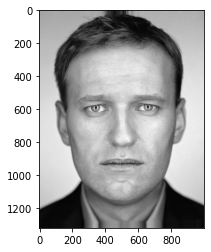

In [3]:
plt.imshow(refImg,cmap="gray")

(660, 500)
(330, 250)
(165, 125)
(83, 63)
(42, 32)
(21, 16)
(11, 8)
Size not a multiple; using resizing func ---> Not correct! (83, 63) (1320, 1000)
Size not a multiple; using resizing func ---> Not correct! (83, 63) (1320, 1000)
Size not a multiple; using resizing func ---> Not correct! (42, 32) (1320, 1000)
Size not a multiple; using resizing func ---> Not correct! (42, 32) (1320, 1000)
Size not a multiple; using resizing func ---> Not correct! (21, 16) (1320, 1000)


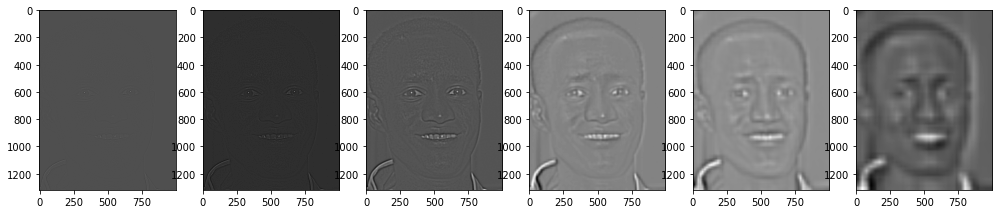

In [4]:
####### Laplacian stack using upsampling and downsampling [Conclusion: output is approx. the same as using gaussian functions]
noOfLevels=6
imgs = [inputImg]
for ni in range(noOfLevels+1):
    imgs.append(cv2.pyrDown(imgs[-1]))
    print(imgs[-1].shape)

def upsample(inp, ref):
    outp = None
    if(inp.shape == ref.shape):
        return inp
    elif(ref.shape[0]%inp.shape[0]==0 and ref.shape[1]%inp.shape[1]==0):
        outp = cv2.pyrUp(inp)
        while(outp.shape!=ref.shape):
            outp = cv2.pyrUp(outp)
    else:
        print("Size not a multiple; using resizing func ---> Not correct!", inp.shape, ref.shape)
        outp = cv2.resize(inp, (ref.shape[1], ref.shape[0]))
    return outp

diffimgs = []
for ni in range(noOfLevels):
    imgni = upsample(imgs[ni].copy(), inputImg.copy())
    imgni1 = upsample(imgs[ni+1].copy(), inputImg.copy())
    diffimgs.append(imgni-imgni1)
    
fig = plt.figure(figsize=(20, 20))
for i in range(noOfLevels):
    fig.add_subplot(1, noOfLevels+1, i+1)
    plt.imshow(diffimgs[i],cmap="gray")

0 2 11
1 4 23
2 8 47
3 16 95
4 32 191
5 64 383


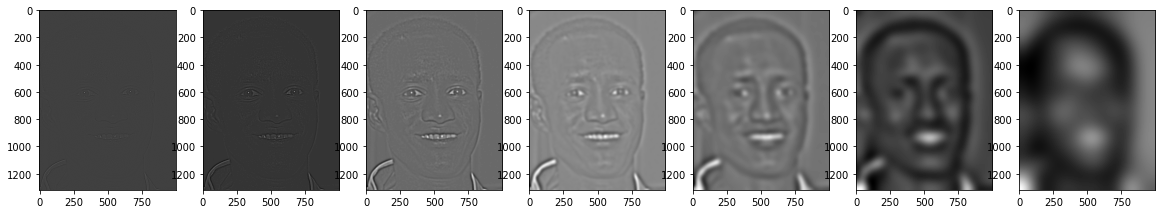

In [4]:
noOfLevels=6
def lapStack(inputImg):
    h,w=np.shape(inputImg)
    lapStack=np.empty((h,w,noOfLevels))

    lap=[]
    for i in range(0,noOfLevels):
        sigma2 = 2**(i+1)
        ksize2 = 6*sigma2-1
        print(i, sigma2, ksize2)
        gaBlur2=cv2.GaussianBlur(inputImg.copy(),(ksize2,ksize2),sigma2,sigma2)
        if(i==0):
            lap.append(inputImg-gaBlur2)
        else:
            sigma1 = 2**i
            ksize1 = 6*sigma1-1
            gaBlur1=cv2.GaussianBlur(inputImg.copy(),(ksize1,ksize1),sigma1,sigma1)
            lap.append(gaBlur1-gaBlur2)
            if(i== noOfLevels-1):
                lap.append(gaBlur2)
    return lap
lapIn=lapStack(inputImg)
fig = plt.figure(figsize=(20, 20))
for i in range(noOfLevels+1):
    fig.add_subplot(1, noOfLevels+1, i+1)
    plt.imshow(lapIn[i],cmap="gray")

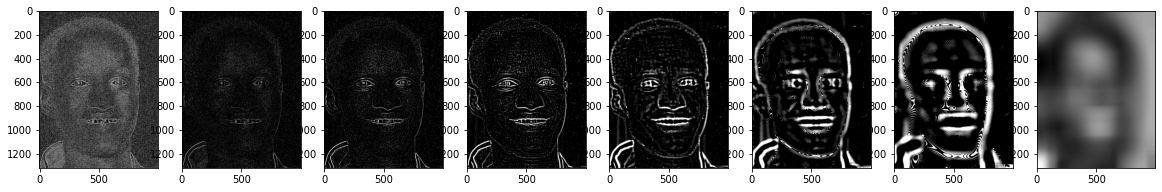

In [4]:
# def lapStack(inputImg):
#     h,w=np.shape(inputImg)
#     noOfLevels=7
#     lapStack=np.empty((h,w,noOfLevels))

#     lap=[]
#     for i in range(0,noOfLevels):
#         k=2*(2**i)+1
#         #k=37
#         gaBlur1=cv2.GaussianBlur(inputImg,(k,k),2**i,2**i)
#         gaBlur2=cv2.GaussianBlur(inputImg,(k,k),2**(i+1),2**(i+1))
#         if(i==0):
#             lap.append(inputImg-gaBlur2)
#         else:
#             lap.append(gaBlur1-gaBlur2)

#     gaBlur2=cv2.GaussianBlur(inputImg,(2*(2**(noOfLevels))+1,2*(2**(noOfLevels))+1),2**(noOfLevels),2**(noOfLevels))
#     lap.append(gaBlur2)
#     return lap
# lapIn=lapStack(inputImg)
# fig = plt.figure(figsize=(20, 20))
# for i in range(8):

#     fig.add_subplot(1, 8, i+1)
#     plt.imshow(lapIn[i],cmap="gray")

0 2 11
1 4 23
2 8 47
3 16 95
4 32 191
5 64 383


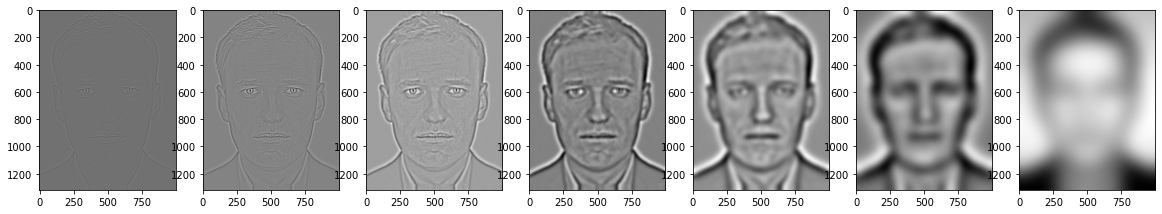

In [5]:
lapRef=lapStack(refImg)
fig = plt.figure(figsize=(20, 20))
for i in range(noOfLevels+1):
    fig.add_subplot(1, noOfLevels+1, i+1)
    plt.imshow(lapRef[i],cmap="gray")

In [6]:

def localEnergyStack(gausStack):
    S=[]
    #gausStack=np.array(gausStack)
    #gausStackSq=np.square(gausStack)
    gausStackSq=[i**2 for i in gausStack]
    
    for i in range(noOfLevels):
        sigma=2**(i+1)
        # c=0
        # if ((5*sigma)%2==0):c=1
        # # S.append(cv2.GaussianBlur(gausStackSq[i],(5*sigma+c,5*sigma+c),sigma,sigma))
        S.append(cv2.GaussianBlur(gausStackSq[i],(6*sigma-1,6*sigma-1),sigma,sigma))
    
    return S

In [7]:
Si=localEnergyStack(lapIn)
Sr=localEnergyStack(lapRef)

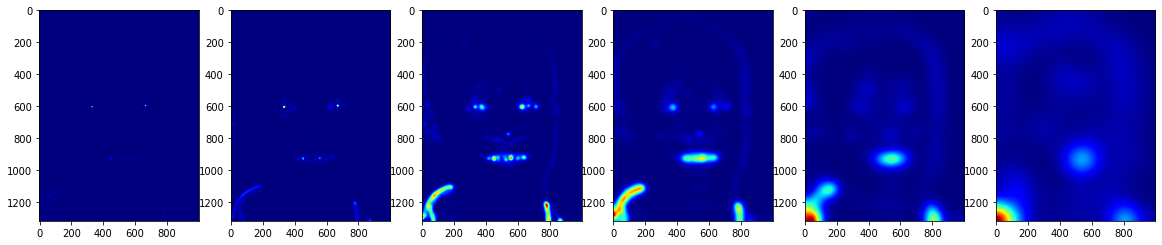

In [8]:
fig = plt.figure(figsize=(20, 20)) 
for i in range(noOfLevels):
    fig.add_subplot(1, noOfLevels, i+1)
    plt.imshow(Si[i],cmap="jet")
    # plt.imshow(Si[i],cmap="Spectral")

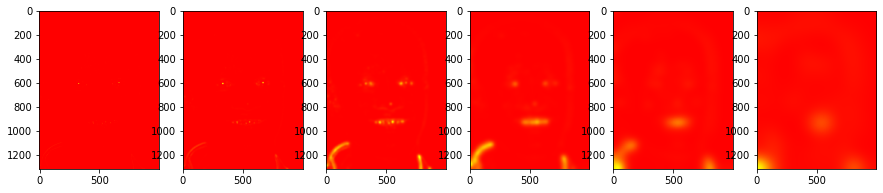

In [9]:
import plotly.express as px
fig = plt.figure(figsize=(15,15)) 
for i in range(noOfLevels):
    
    fig.add_subplot(1, noOfLevels, i+1)
    #sn.heatmap(data=np.array(Si[i]))
    #sn.show()
    plt.imshow( Si[i] , cmap = 'autumn' , interpolation = 'nearest' )


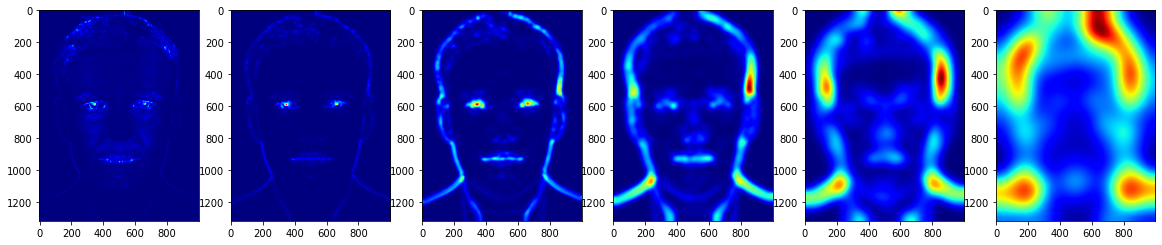

In [10]:
fig = plt.figure(figsize=(20, 20)) 
for i in range(noOfLevels):

    fig.add_subplot(1, noOfLevels, i+1)
    plt.imshow(Sr[i],cmap="jet")

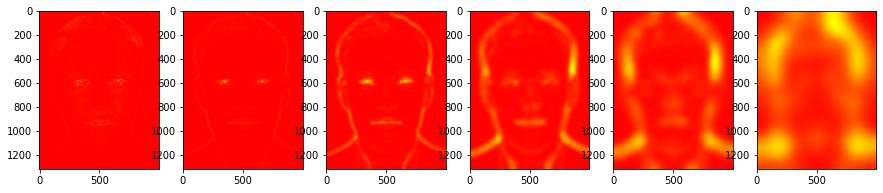

In [11]:

fig = plt.figure(figsize=(15,15)) 
for i in range(noOfLevels):
    
    fig.add_subplot(1, noOfLevels, i+1)
    #sn.heatmap(data=np.array(Si[i]))
    #sn.show()
    plt.imshow( Sr[i] , cmap = 'autumn' , interpolation = 'nearest' )


taking wraped1 as the output of wrapping operation from the given input and ref images.
# need to connect the dense corresponding function

In [12]:
from WrapOperator import wrapOperator

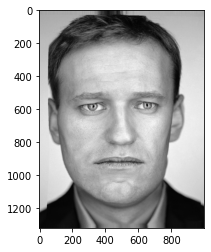

In [13]:
#wrapImg=cv2.imread("../data/inputs/p1.png",0)
import pandas as pd

## Wrap function
style_lm = np.array(pd.read_csv('../data/inputs/style.lm', header=None),dtype='float32')
input_lm = np.array(pd.read_csv('../data/inputs/p1.lm', header=None),dtype='float32')

vy, vx, yy, xx =wrapOperator(style_img=refImg.copy(), input_img=inputImg.copy(), style_lm=style_lm, input_lm=input_lm)
wrapRef = np.ones(refImg.shape)
wrapRef[yy.astype(int), xx.astype(int)] = refImg[vy, vx]
plt.imshow(wrapRef,cmap="gray")


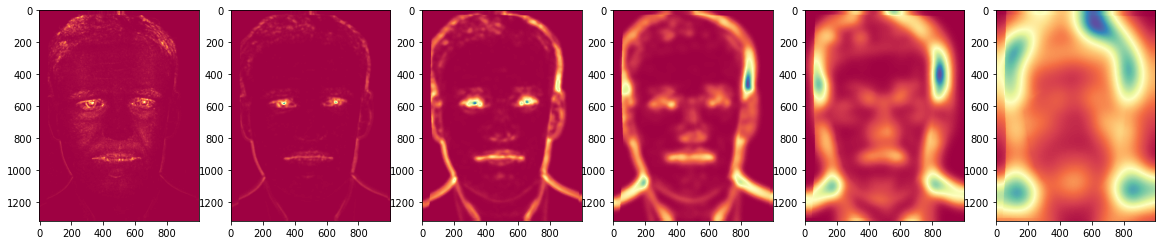

In [14]:
#wrapping the refImg local energy stack

wrLoRe=[]
for i in range(noOfLevels):
    # wrLoRe.append(wrapOperator(style_img=Sr[i], input_img=inputImg, style_lm='../data/inputs/style.lm', input_lm='../data/inputs/p1.lm') )
    tempwarp = np.ones(Sr[i].shape)
    tempwarp[yy.astype(int), xx.astype(int)] = Sr[i][vy, vx]
    wrLoRe.append(tempwarp)

fig = plt.figure(figsize=(20, 20)) 
for i in range(noOfLevels):

    fig.add_subplot(1, noOfLevels, i+1)
    plt.imshow(wrLoRe[i],cmap="Spectral")

In [15]:
##Robust Transfer

#calculating the gain
norSi=Si/np.max(Si)
gain=np.sqrt(np.array(wrLoRe)/(np.array(norSi)+0.0001))
print(gain.shape,inputImg.shape)

#robust gain


(7, 1320, 1000) (1320, 1000)


In [25]:
print(np.max(gain),np.min(gain))

56.36018619766345 0.0


In [26]:
##threshold the gain bw 0.9 to 2.8
gain[gain>2.8]=2.8
gain[gain<0.9]=0.9
print(np.max(gain),np.min(gain))

2.8 0.9


In [16]:
lapout=[]
robGain=[]
for i in range(7):
    robGain.append(cv2.GaussianBlur(gain[i],(5*(3*(2**(7)))+1,5*(3*(2**(7)))+1),3*(2**(7)),(3*(2**(7)))))
    lapout.append(lapIn[i]*robGain[i])

In [17]:
resOut=wrapOperator(style_img=lapIn[7], input_img=inputImg, style_lm='../data/inputs/style.lm', input_lm='../data/inputs/p1.lm')

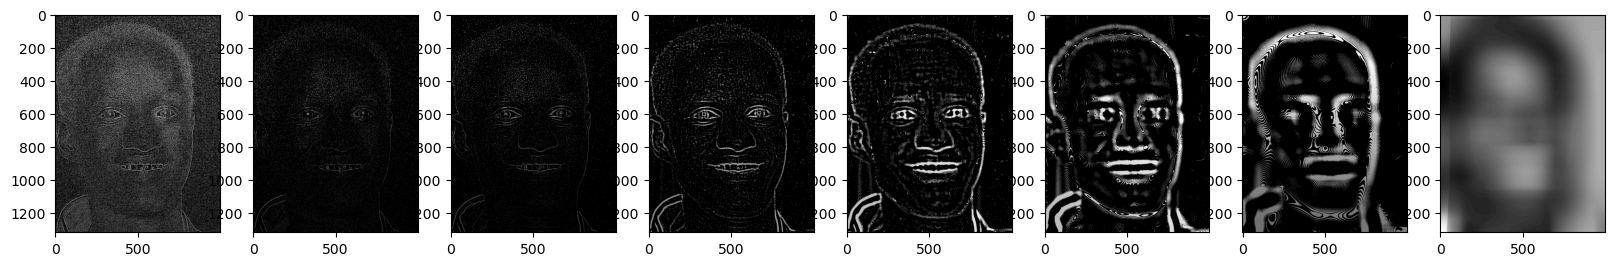

In [18]:
fig = plt.figure(figsize=(20, 20))

for i in range(7):

    fig.add_subplot(1, 8, i+1)
    plt.imshow(lapout[i],cmap="gray")

fig.add_subplot(1, 8, 8)
plt.imshow(resOut,cmap="gray")

In [ ]:
## find the reconstructed output from laplacian pyramids and the residue

